 # Homework 6
 ### By Franklin Marsh
 ### MATH0154 Computational Statistics
 ### with Prof. Gabe Chandler


 ## Problem 1

Consider generating data from a some density $f(x)$ (pick something nice so that you can use both the 'rdist' and 'ddist' functions in R to get your random sample and compute the truth, respectively, easily).  Based on a random sample of size $n$, we would like to estimate this function.  We will use a kernel smoother, which you will write.  Use a truncated normal distribution as your kernel function.\\[5pt]

We need to specify the bandwidth for our kernel smoother.  Consider 3 ideas from class for estimating this quantity:

a) leave one out cross validation where we try to maximize the likelihood (so we look at $\prod \hat{f}_h^{-i}(x_i)$)\\

b) the same as a, but instead of a product, use the sum. 

c) Training the data on a random half of the data, testing it on the other half (via a or b) and then scaling down your bandwidth, based on the theoretical optimal bandwidth rate (the bandwidth should be of the order $n^{-1/5}$)\\
Compare all of these to the optimal bandwidth, defined here to be the bandwidth for which the estimate $f_h(x)$ minimizes $\int |\hat{f}_h(x)-f(x)|dx.$ (Once you have written a code to do kernel density estimation, feel free to use the {\it density} function in R to run the simulations to speed up your code.) 

In [20]:
#install.packages('truncnorm', repos="http://cran.rstudio.com/")
library(truncnorm)

kernel <- function(x, mu, bw) {
    
    #truncated normal distribution kernel
    return(dtruncnorm(x, a = c(-2), b = c(2), mean = mu, sd = bw))
}

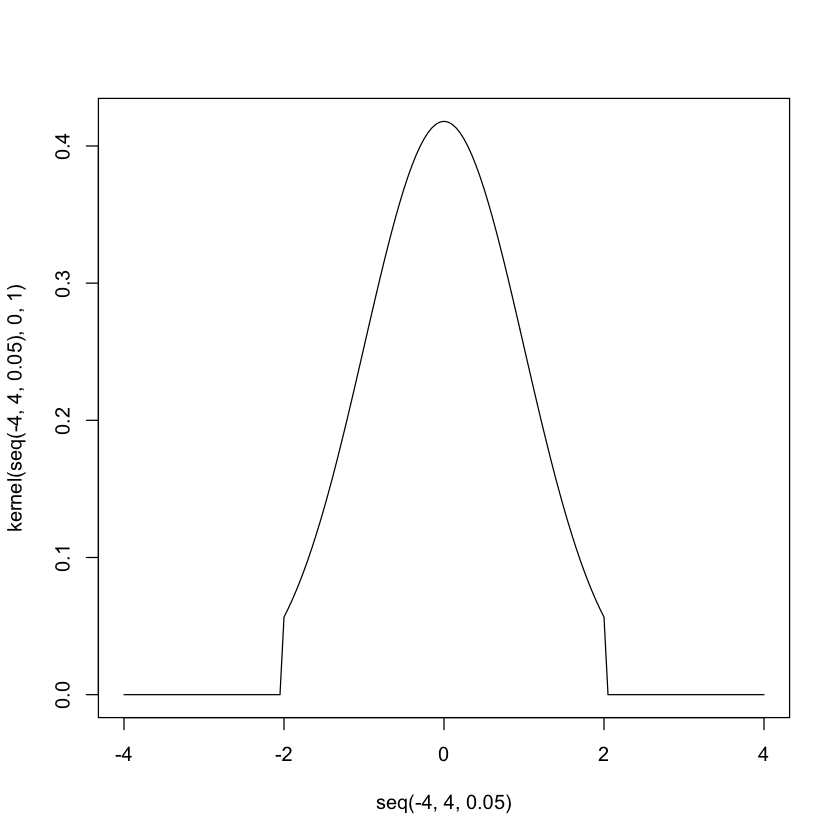

In [25]:
plot(seq(-4, 4, 0.05),kernel(seq(-4, 4, 0.05), 0, 1), type = 'l')

In [75]:
KDensity <- function(x_vals, obs, bw) {
    
    kernels <- c()
    y_vals <- c()
    
    i <- 1 # set observation counter to zero
    j <- 1 #set abcissa counter to zero
    
    for (x in x_vals) {
         
        for (ob in obs) {
            kernels[i] <- dtruncnorm(x, a = c(-4), b = c(4), mean = ob, sd = bw)
            i <- i + 1
        }
        
        y_vals[j] <- sum(kernels)
        
        j <- j + 1
        i <- 1
    }
    return(y_vals/length(obs))
}

In [67]:
my_obs <- rnorm(100)
my_abcissa <- seq(-4,4,0.01)

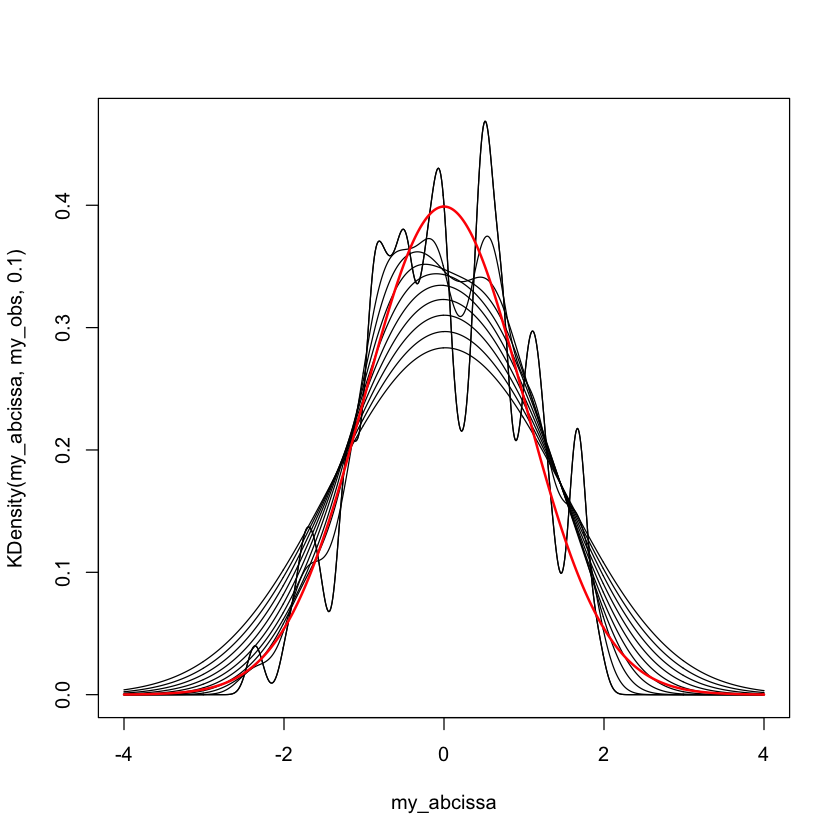

In [76]:
plot(my_abcissa,KDensity(my_abcissa, my_obs, 0.1), type = 'l')

for (bandwidth in seq(0.1,1.0, 0.1)) {
    lines(my_abcissa,KDensity(my_abcissa, my_obs, bandwidth), type = 'l')
}

lines(my_abcissa, dnorm(my_abcissa), col = 'red', lwd = 2)

In [178]:
SumCV <- function(my_obs, bandwidth) {
    
    sum_terms <- c()
    
    output <- c()
    j <- 1 
    
    for (bw in bandwidth) {
    
        for (i in (1:length(my_obs))) {
            sum_terms[i] <- KDensity(my_obs[i], my_obs[-i], bw)
    
        }
    
        output[j] <- sum(sum_terms)
        j <- j + 1
        
        }
    
    return(list(bandwidth,output/max(output)))
}

ProdCV <- function(my_obs, bandwidth) {
    
    sum_terms <- c()
    
    output <- c()
    j <- 1 
    
    for (bw in bandwidth) {
    
        for (i in (1:length(my_obs))) {
            sum_terms[i] <- KDensity(my_obs[i], my_obs[-i], bw)
    
        }
    
        output[j] <- prod(sum_terms)
        j <- j + 1
        
        }
    
    return(list(bandwidth,output/max(output)))
}

In [127]:
TrainTestSplit <- function(obs, test_size) {
    
    split_frac <- as.integer(1.0/test_size)
    
    test_i <- sample((1:length(obs)),length(obs)/split_frac)
    train_i <- (1:length(obs))[-test_i]

    if ((sum(test_i) + sum(train_i)) == sum(1:length(obs))) {
        train <- obs[train_i]
        test <- obs[test_i]
    }

    else {
        stop("Error, sum of split parts did not equal some of the whole")
    }
    
    return(list(train,test))
}

In [131]:
my_split <- TrainTestSplit(my_obs, 0.5)

In [168]:
SplitCV <- function(train, test, bandwidth, kind = 'sum') {
        
    output <- c()
    j <- 1 
    
    if (kind == 'sum') {
    
        for (bw in bandwidth) {
        
            output[j] <- sum(abs(KDensity(test, train, bw)))
        
            j <- j + 1
        
    }
            
    }
    
    else if (kind == 'prod') {
    
        for (bw in bandwidth) {
        
            output[j] <- prod(abs(KDensity(test, train, bw)))
        
            j <- j + 1
        
    }
    
    }
    
    mod_bandwidth <- ((length(train) + length(test))/length(train))^(-1.0/5.0)*bandwidth
    
    return(list(mod_bandwidth,output/max(output)))
    
}

In [180]:
bw_range <- seq(0.01,1.0,0.01)
sum_split_cv <- SplitCV(my_split[[1]], my_split[[2]], bw_range, kind = 'sum')
prod_split_cv <- SplitCV(my_split[[1]], my_split[[2]], bw_range, kind = 'prod')
sum_cv <- SumCV(my_obs, bw_range)
prod_cv <- ProdCV(my_obs, bw_range)

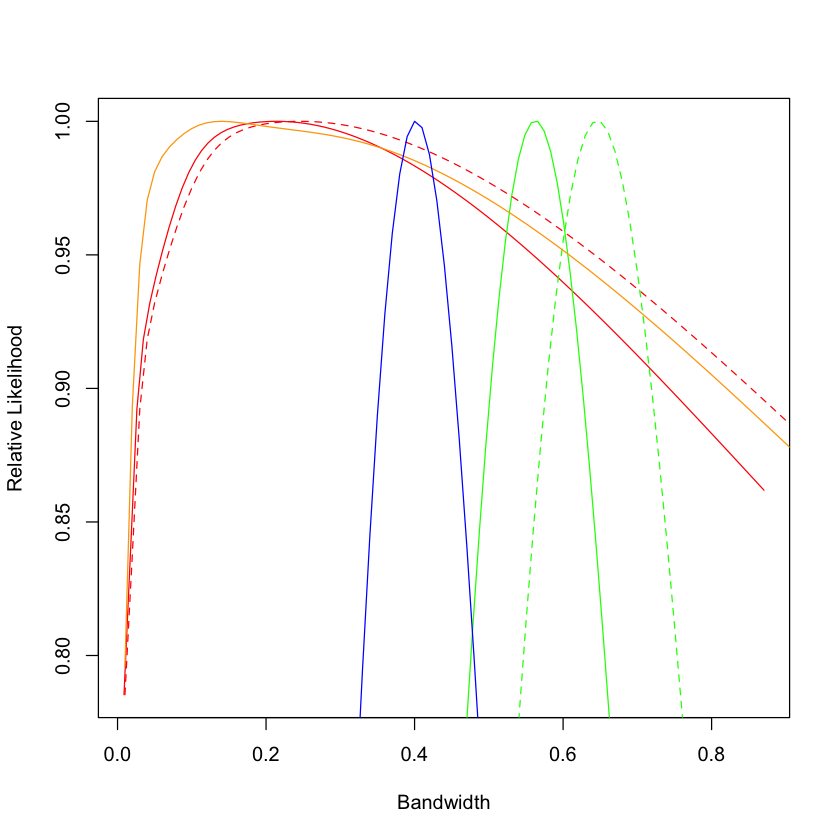

In [184]:
plot(sum_split_cv[[1]], sum_split_cv[[2]], type = 'l', col = 'red',
    xlab = 'Bandwidth', ylab = 'Relative Likelihood')
lines(prod_split_cv[[1]], prod_split_cv[[2]], type = 'l', col = 'green')

lines(bw_range, sum_split_cv[[2]], type = 'l', col = 'red', lty = 2)
lines(bw_range, prod_split_cv[[2]], type = 'l', col = 'green', lty = 2)

lines(sum_cv[[1]], sum_cv[[2]], type = 'l', col = 'orange')
lines(prod_cv[[1]], prod_cv[[2]], type = 'l', col = 'blue')

 ## Problem 2

Consider seeing data from a density defined as follows:
\begin{eqnarray}
f(x)=\left\{ \nonumber
\begin{array}{ll}
0.05  & \mbox{for }|x|\leq0.13\\
0.987[\phi(x)+\phi(|x|-0.13)] & \mbox{for }0.13<|x|<0.26\\
0.987\phi(x) & \mbox{for }|x|\geq 0.26,\\
\end{array}\right.
\end{eqnarray}
where $\phi(x)$ is the standard normal pdf.

a. Use acceptance sampling to generate from this density.

b. See if density estimation using optimal bandwidths (you can just use the default in the R density function to do this) can detect the hole in the middle, with $n=500$.

c. Suggest some quantity that is better than density estimation at detecting the bi-modality of this density based on a random sample and present some simulations to show this. 


In [24]:
g <- function(x) {
    return(dnorm(x))
}

f <- function(x) {
    
    output <- c()
    j <- 0
    
    for (i in x) {
        j <- j + 1
        
        if (abs(i) < 0.13) {
            output[j] <- 0.05
        }
    
        else if (abs(i) < 0.26) {
            output[j] <- (0.987*(dnorm(i) + dnorm(abs(i) - 0.13)))
        }
    
        else {
            output[j] <- (0.987*(dnorm(i)))
        }
        
    }
    
    return(output)
    
}

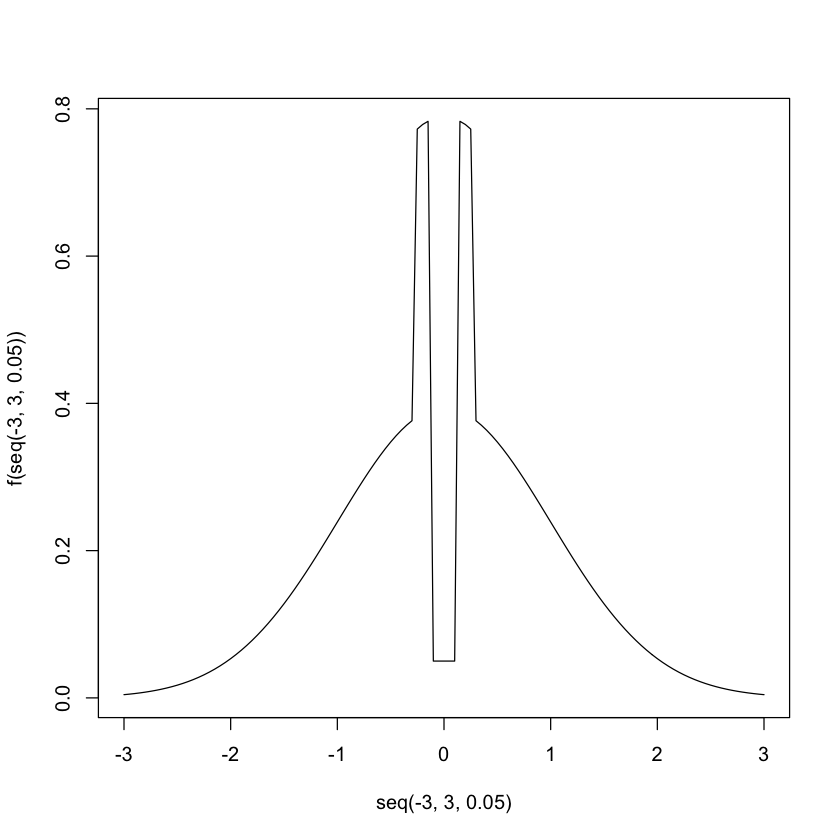

In [78]:
plot(seq(-3,3, 0.05),f(seq(-3,3, 0.05)), type = 'l')

In [134]:
MaskingDraw <- function(maskdraw, maskpdf, goalpdf, c, n_iters) {
    
    # Draw from pdf (goalpdf) using the masking technique
    # 
    # Args:
    #     maskdraw: a function that draws from the masking dist.
    #     maskpdf: a function that returns the pdf of the masking dist when given an x.
    #     goalpdf: the pdf of the function that we are trying draw from
    #     c: the c normalizing constant for maskpdf and goalpdf
    #     n_iters: number of points that we want to draw
    #
    # Returns:
    #     out: randoom numbers like they were drawn from goalpdf
    
    out <- c(NaN) #initialize empty output
        
    while (length(out[!is.na(out)]) < n_iters) {
        
        pull <- maskdraw(1) #the initial value we are pulling from the masking distribution
        crit <- (goalpdf(pull))/(c*maskpdf(pull))
                
        U <- runif(1)
        
        if (U <= crit) {
            out[i] <- pull
            }
    }
    return(out[!is.na(out)])
    }

FindC <- function(maskpdf, targetpdf, prange = seq(-3,3,0.01), by = 0.01) {
    
    # Finds the normalizing coefficient c for drawing using the masking technique
    #
    # Args:
    #     maskpdf:
    #     targetpdf:
    #     param1:
    #     prange:
    #     by:
    # Returns:
    #     c: normalizing coefficient
    
    grid <- seq(min(prange),max(prange), by)
    
    c <- max((targetpdf(grid))/(maskpdf(grid)))
    
    return(c)
}

In [135]:
c <- FindC(g, f) #find the acceptance-rejection sampling constant

In [ ]:
#draw the sample of 500 points
sample <- MaskingDraw(rnorm, g, f, FindC(g, f), 1000)
print(length(sample))
sample <- sample[1:500] #reduce the sample to 500 observations
print(length(sample))

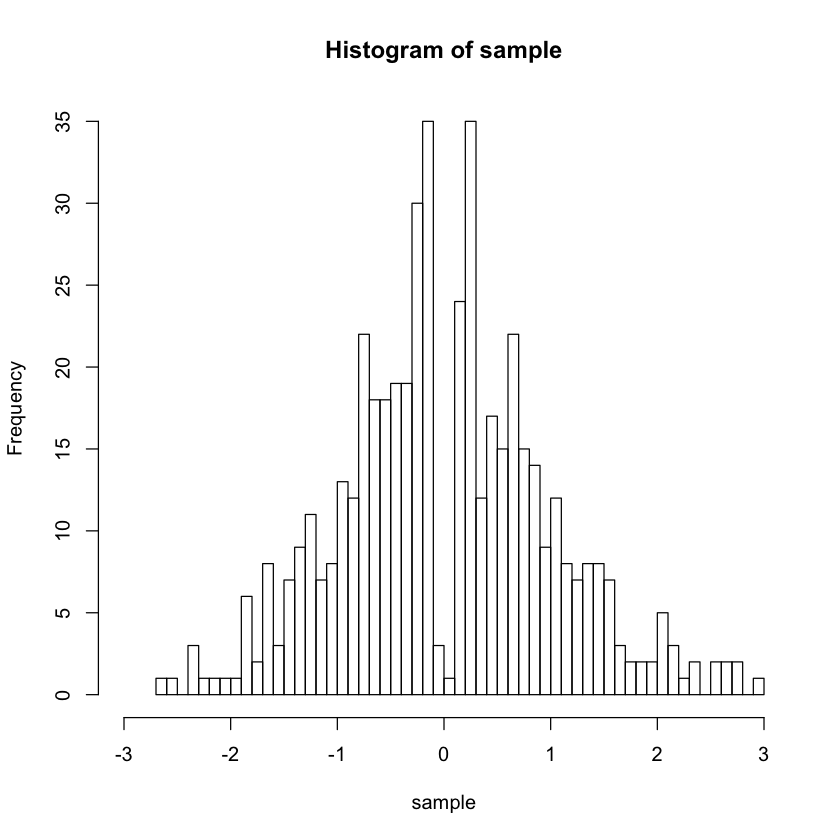

In [76]:
hist(sample, breaks = 50, xlim = c(-3,3))

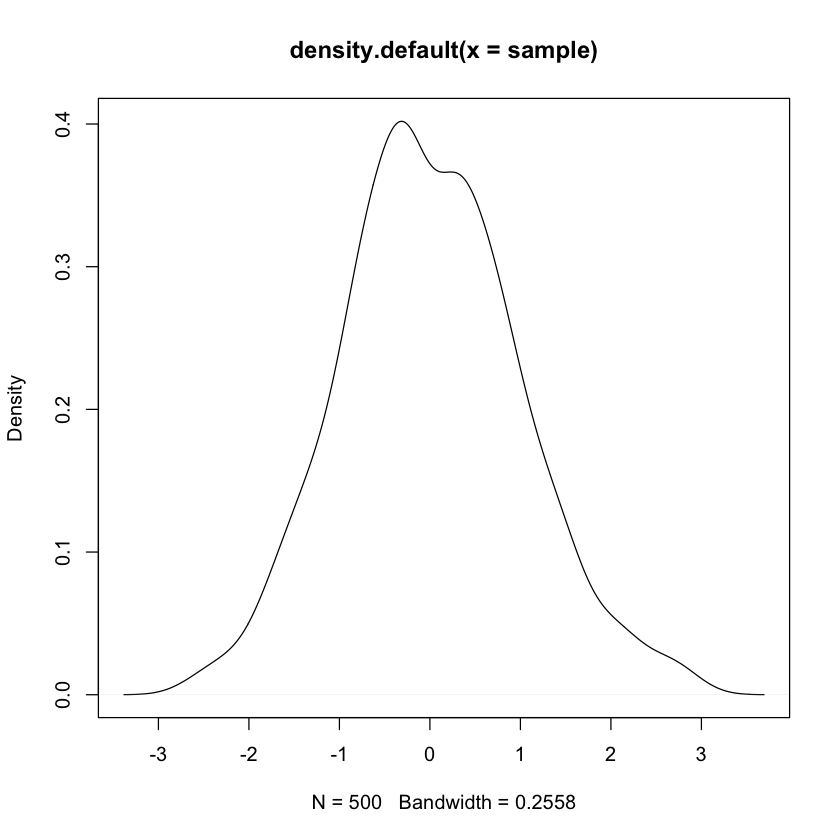

In [77]:
plot(density(sample))

The estimate above does capture a small decrease in the density near $x = 0$, however, the true extent of the bi-modality is not well captured. In the next cell, we will derive a statistic that can measure if the distribution is normal.

In [121]:
InCenter <- function(ob, center = 0.13) {
    
    if (abs(ob) <= center) {
        return(TRUE)
    }
    else {
        return(FALSE)
    }
}

NormStat <- function(obs, center) {
    return(length(Filter(InCenter, obs))/length(obs))
}

In [129]:
print(NormStat(sample, 0.13))


print(NormStat(rnorm(500), 0.13))

[1] 0.014
[1] 0.114
